In [1]:
import numpy as np
import xsimlab as xs

@xs.process
class GameOfLife:
    world = xs.variable(dims=('x', 'y'), intent='inout')

    def run_step(self):
        nbrs_count = sum(
            np.roll(np.roll(self.world, i, 0), j, 1)
            for i in (-1, 0, 1) for j in (-1, 0, 1)
            if (i != 0 or j != 0)
        )
        self._world_next = (nbrs_count == 3) | (self.world & (nbrs_count == 2))

    def finalize_step(self):
        self.world[:] = self._world_next


@xs.process
class Glider:
    pos = xs.variable(dims='point_xy', description='glider position')
    world = xs.foreign(GameOfLife, 'world', intent='out')

    def initialize(self):
        x, y = self.pos

        kernel = [[1, 0, 0],
                  [0, 1, 1],
                  [1, 1, 0]]

        self.world = np.zeros((10, 10), dtype=bool)
        self.world[x:x+3, y:y+3] = kernel

In [2]:
model = xs.Model({'gol': GameOfLife,
                  'init': Glider})

In [3]:
model.gol

<GameOfLife 'gol' (xsimlab process)>
Variables:
    world    [inout] ('x', 'y') 
Simulation stages:
    run_step
    finalize_step

In [4]:
model.init

<Glider 'init' (xsimlab process)>
Variables:
    pos         [in] ('point_xy',) glider position
    world      [out] ---> gol.world
Simulation stages:
    initialize

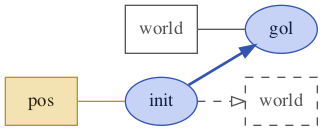

In [8]:
model.visualize(show_inputs=True, show_variables=True)

In [34]:
model.input_vars_dict

{'init': ['pos']}

In [38]:
model.dependent_processes

{'gol': ['init'], 'init': []}

In [47]:
 output_vars={'gol__world': 'step'}

In [48]:
def as_variable_key(key):
    """Returns ``key`` as a tuple of the form
    ``('process_name', 'var_name')``.
    If ``key`` is given as a string, then process name and variable
    name must be separated unambiguously by '__' (double underscore)
    and must not be empty.
    """
    key_tuple = None

    if isinstance(key, tuple) and len(key) == 2:
        key_tuple = key

    elif isinstance(key, str):
        key_split = key.split("__")
        if len(key_split) == 2:
            p_name, var_name = key_split
            if p_name and var_name:
                key_tuple = (p_name, var_name)

    if key_tuple is None:
        raise ValueError(f"{key!r} is not a valid input variable key")

    return key_tuple

In [52]:
flatten_vars = {}

for clock, out_vars in output_vars.items():
    print(clock, out_vars)
    if isinstance(out_vars, dict):
        print('hello')
        var_list = []
        for p_name, var_names in out_vars.items():
            if isinstance(var_names, str):
                var_list.append((p_name, var_names))
            else:
                var_list += [(p_name, vname) for vname in var_names]
                
    elif isinstance(out_vars, (tuple, str)):
        print('hello2')
        var_list = [as_variable_key(out_vars)]

    elif isinstance(out_vars, list):
        print('hello3')
        var_list = [as_variable_key(k) for k in out_vars]

    else:
        print('hello4')
        raise ValueError(
            f"Cannot interpret {out_vars!r} as valid output variable key(s)"
        )

gol__world step
hello2


ValueError: 'step' is not a valid input variable key

In [46]:
var_list

[('gol', 'world')]

In [8]:
input_dataset = xs.create_setup(
    model=model,
    clocks={'step': np.arange(9)},
    input_vars={'init__pos': ('point_xy', [4, 5])},
    output_vars={'step': ['gol__world']}
)


In [9]:
output_dataset = input_dataset.xsimlab.run(model=model)

In [10]:
output_dataset

<xarray.Dataset>
Dimensions:     (point_xy: 2, step: 9, x: 10, y: 10)
Coordinates:
  * step        (step) int64 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: point_xy, x, y
Data variables:
    init__pos   (point_xy) int64 4 5
    gol__world  (step, x, y) bool False False False False ... False False False

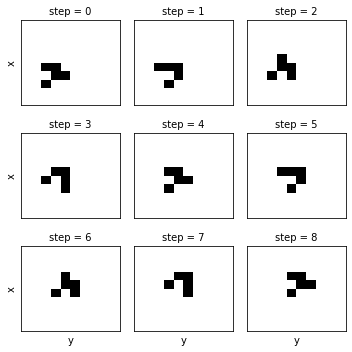

In [11]:
import matplotlib.pyplot as plt
 
with model:
    (input_dataset
    .xsimlab.update_vars(
      input_vars={'init__pos': ('point_xy', [2, 2])}
    )
    .xsimlab.run()
    .gol__world.plot.imshow(
      col='step', col_wrap=3, figsize=(5, 5),
      xticks=[], yticks=[],
      add_colorbar=False, cmap=plt.cm.binary)
    )

# MODEL 2

In [2]:
import numpy as np

import xsimlab as xs

import matplotlib.pyplot as plt

In [20]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.variable(dims="x", intent="out")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

TypeError: variable() got an unexpected keyword argument 'static'

In [19]:
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

TypeError: variable() got an unexpected keyword argument 'groups'

In [11]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse")
    scale = xs.variable(description="scale of initial pulse")
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [12]:
model2 = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

In [15]:
in_ds = xs.create_setup(
     model=model2,
     clocks={
         'time': np.linspace(0., 1., 101),
         'otime': [0, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'grid': {'length': 1.5, 'spacing': 0.01},
         'init': {'loc': 0.3, 'scale': 0.1},
         'advect__v': 1.
     },
     output_vars={
         'grid__x': 'time',
         'profile__u': 'otime'
     }
 )

ValueError: 'time' is not a valid input variable key